In [48]:
#import the libraries
import psycopg2
import geopandas as gpd
from shapely.geometry import Point, Polygon
#import contextily as cx
#import osmnx as ox
import shapely

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import shap

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import tensorflow as tf

In [49]:
new_model = tf.keras.models.load_model('model2.keras')

In [50]:
new_model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 79)]              0         
                                                                 
 dense_48 (Dense)            (None, 256)               20480     
                                                                 
 dropout_35 (Dropout)        (None, 256)               0         
                                                                 
 dense_49 (Dense)            (None, 256)               65792     
                                                                 
 dropout_36 (Dropout)        (None, 256)               0         
                                                                 
 dense_50 (Dense)            (None, 256)               65792     
                                                                 
 dropout_37 (Dropout)        (None, 256)               0  

In [51]:
amenity_count_model=pd.read_csv("amenity_count_model.csv").drop(columns=["Unnamed: 0", "count"])
amenity_count_model.head()

,point_id,amenity_count_bicycle_parking,amenity_count_parking_entrance,amenity_count_atm,amenity_count_charging_station,amenity_count_pharmacy,amenity_count_parking,amenity_count_taxi,amenity_count_bank,amenity_count_post_office,...,building_count_toilets,building_count_supermarket,building_count_container,building_count_bridge,building_count_electricity,building_count_farm_auxiliary,building_count_cabin,building_count_silo,building_count_fire_station,food_and_bev
0,POINT (1461340.7192 6898629.5709),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,POINT (1461540.7192 6898629.5709),0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,POINT (1462140.7192 6898629.5709),0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,POINT (1462340.7192 6898629.5709),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,POINT (1462540.7192 6898629.5709),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
amenity_count_model.describe()

,amenity_count_bicycle_parking,amenity_count_parking_entrance,amenity_count_atm,amenity_count_charging_station,amenity_count_pharmacy,amenity_count_parking,amenity_count_taxi,amenity_count_bank,amenity_count_post_office,amenity_count_place_of_worship,...,building_count_toilets,building_count_supermarket,building_count_container,building_count_bridge,building_count_electricity,building_count_farm_auxiliary,building_count_cabin,building_count_silo,building_count_fire_station,food_and_bev
count,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,...,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000
mean,6.134869,0.678039,0.359662,0.290091,0.251014,0.187926,0.127571,0.114425,0.067489,0.065443,...,0.048819,0.048367,0.040544,0.038045,0.038299,0.031218,0.030259,0.026257,0.027669,1.932529
std,14.614518,1.786352,1.227225,0.820825,0.655862,0.642800,0.416426,0.522322,0.274843,0.301308,...,0.254129,0.272339,0.384642,0.278365,0.269874,0.366661,0.528157,0.436711,0.243032,5.420978
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,167.000000,27.000000,18.000000,14.000000,7.000000,12.000000,8.000000,8.000000,4.000000,6.000000,...,4.000000,8.000000,10.000000,9.000000,8.000000,13.000000,20.000000,20.000000,6.000000,105.000000


In [53]:
X_train, X_test, y_train, y_test = train_test_split(amenity_count_model.drop(columns=["point_id","food_and_bev","amenity_count_atm"]), amenity_count_model["food_and_bev"], test_size = 0.3, random_state = 101)
#divide the test dataset in test and validation
X_test_2_, X_val,  y_test_, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 101)

In [54]:
scaler = StandardScaler()
X_train_nor =  scaler.fit_transform(X_train)
X_test2_nor =  scaler.transform(X_test_2_)
X_val_nor =  scaler.transform(X_val)

In [55]:
# Evaluate the restored model
loss, acc = new_model.evaluate(X_test2_nor, y_test_, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
print(new_model.predict(X_test2_nor).shape)

259/259 - 0s - loss: 2.5795 - mean_squared_error: 2.5795 - 473ms/epoch - 2ms/step
Restored model, accuracy: 257.95%
259/259 [==============================] - 0s 814us/step
(8284, 1)


In [56]:
predictions = new_model.predict(X_test2_nor)#.round(0)
r2 = r2_score(y_test_, predictions)
r2

259/259 [==============================] - 0s 807us/step


0.9144988694548146

In [57]:
dataset_predict = amenity_count_model.drop(columns=["point_id","food_and_bev","amenity_count_atm"])

In [58]:
scaler = StandardScaler()
dataset_predict =  scaler.fit_transform(dataset_predict)

In [59]:
predictions = new_model.predict(dataset_predict)#.round(0)


1726/1726 [==============================] - 1s 794us/step


In [60]:
df = amenity_count_model.copy()
df["prediction"] = predictions
df["food_and_bev"] = amenity_count_model["food_and_bev"]

In [61]:
df.describe()

,amenity_count_bicycle_parking,amenity_count_parking_entrance,amenity_count_atm,amenity_count_charging_station,amenity_count_pharmacy,amenity_count_parking,amenity_count_taxi,amenity_count_bank,amenity_count_post_office,amenity_count_place_of_worship,...,building_count_supermarket,building_count_container,building_count_bridge,building_count_electricity,building_count_farm_auxiliary,building_count_cabin,building_count_silo,building_count_fire_station,food_and_bev,prediction
count,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,...,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000,55224.000000
mean,6.134869,0.678039,0.359662,0.290091,0.251014,0.187926,0.127571,0.114425,0.067489,0.065443,...,0.048367,0.040544,0.038045,0.038299,0.031218,0.030259,0.026257,0.027669,1.932529,1.848044
std,14.614518,1.786352,1.227225,0.820825,0.655862,0.642800,0.416426,0.522322,0.274843,0.301308,...,0.272339,0.384642,0.278365,0.269874,0.366661,0.528157,0.436711,0.243032,5.420978,5.006157
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025950
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.145468
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.265222
75%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.938287
max,167.000000,27.000000,18.000000,14.000000,7.000000,12.000000,8.000000,8.000000,4.000000,6.000000,...,8.000000,10.000000,9.000000,8.000000,13.000000,20.000000,20.000000,6.000000,105.000000,96.299637


In [62]:
df = df[(df["food_and_bev"]>0)|(df["prediction"]>=0.4)]

In [63]:
df.shape

(25087, 83)

In [64]:
df=df[["point_id", "prediction", "food_and_bev"]]

In [65]:
r2_score(df["food_and_bev"], df["prediction"])

0.9395545288110537

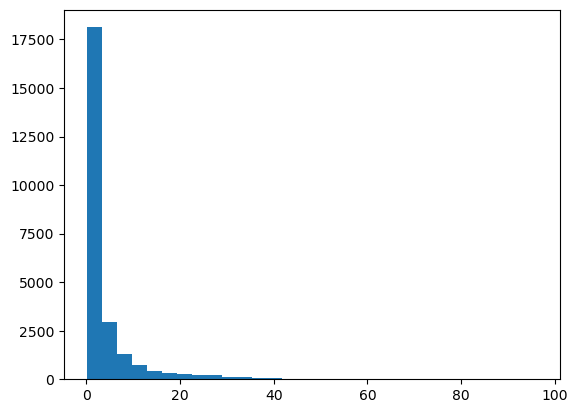

In [66]:
plt.hist(df["prediction"], bins=30)
plt.show()

In [67]:
#df["prediction"] = df["prediction"].apply(lambda x: min(max(x, 0), 30 ))

In [68]:
#df["prediction"] = df["prediction"]*10

In [69]:
df["gap"] = df["prediction"] - df["food_and_bev"]

In [70]:
df.describe()

,prediction,food_and_bev,gap
count,25087.000000,25087.000000,25087.000000
mean,3.855417,4.254076,-0.398659
std,6.912484,7.403687,1.776051
min,0.056522,0.000000,-26.023367
25%,0.511769,1.000000,-0.915729
50%,1.153018,1.000000,-0.343012
75%,3.765578,4.000000,0.551042
max,96.299637,105.000000,13.756205


In [71]:
from shapely import wkt
df["point_id"] = gpd.GeoSeries.from_wkt(df["point_id"])


In [72]:
gdf = gpd.GeoDataFrame(df, geometry="point_id")

In [73]:
gdf['point_id'] = gdf['point_id'].apply(lambda x : x.centroid if type(x) == Polygon else x)

In [74]:
gdf.crs = "EPSG:3857"

In [75]:
gdf_plot=gdf.to_crs(epsg=3857)

In [86]:
gdf.to_crs(epsg=3857).explore("prediction", marker_type='circle', cmap = 'viridis_r' ,style_kwds={'stroke':True, 'fillOpacity':.5}, marker_kwds={'radius': 100}) 
#marker_kwds={'radius':'prediction'}
#style_kwds={'stroke':False, 'fillOpacity':0.5}

In [77]:
gdf_2 = gdf.copy()

In [211]:
#gdf_2["prediction"]=round(gdf_2["prediction"],0)
#gdf_2["prediction_s"] = gdf_2["prediction"].apply(lambda x: max(x, 1))

In [78]:
gdf_2

,point_id,prediction,food_and_bev,gap
7,POINT (1463140.719 6898629.571),0.282212,1,-0.717788
8,POINT (1463740.719 6898629.571),0.455623,1,-0.544377
9,POINT (1463940.719 6898629.571),0.264895,1,-0.735105
27,POINT (1510740.719 6899029.571),2.116772,3,-0.883228
28,POINT (1510740.719 6898029.571),0.442927,3,-2.557073
...,...,...,...,...
54928,POINT (1519540.719 6867829.571),0.446805,0,0.446805
55122,POINT (1518340.719 6866829.571),0.075666,1,-0.924334
55123,POINT (1518540.719 6866829.571),0.078516,1,-0.921484
55157,POINT (1518340.719 6866629.571),0.079942,1,-0.920058


In [79]:
def buffer(row):
     return row.point_id.buffer(row.prediction_s)


In [80]:
#gdf_2['point_id'] = gdf_2.apply(buffer, axis=1)
gdf_2['point_id'] = gdf_2.buffer(200)

In [89]:
#heatmap for prediction
gdf_2.to_crs(epsg=3857).explore("prediction", cmap = 'viridis_r',style_kwds={'stroke':False, 'fillOpacity':0.3})

In [87]:
#heatmap for actual values
gdf_2.to_crs(epsg=3857).explore("food_and_bev", cmap = 'viridis_r',style_kwds={'stroke':False, 'fillOpacity':0.3})

In [88]:
#heatmap for gap: prediction - actual values 
#gdf_2.to_crs(epsg=3857).explore("gap", cmap = 'viridis_r',style_kwds={'stroke':False, 'fillOpacity':0.3})

In [84]:
gdf_3 = gdf_2.copy()
gdf_3 = gdf_3[gdf_3["gap"]>0]

In [90]:
#heatmap for gap: prediction - actual values, filtering only positive gaps
gdf_3.to_crs(epsg=3857).explore("gap", cmap = 'viridis_r',style_kwds={'stroke':False, 'fillOpacity':0.3})